In [1]:
 from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import pandas as pd
from torchvision import datasets, transforms
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

#Load data

In [3]:
# load train
link_data_train = '/content/gdrive/MyDrive/Đồ án CS331.N12/dataset/training_set'
data_train = pathlib.Path(link_data_train)
link_img_train = (datasets.ImageFolder(link_data_train)).imgs
link_img_train = np.asarray(link_img_train)
# load test
link_data_test = '/content/gdrive/MyDrive/Đồ án CS331.N12/dataset/test_set'
# data_test = pathlib.Path(link_data_test)
link_img_test = np.asarray((datasets.ImageFolder(link_data_test)).imgs)

In [4]:
img_h, img_w, img_d = 224, 224, 3
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_train,
                                                               label_mode = 'categorical',
                                                               image_size = (img_h, img_w),
                                                               batch_size = batch_size)
class_names = train_ds.class_names
class_names

Found 900 files belonging to 10 classes.


['beaches',
 'bus',
 'dinosaurs',
 'elephants',
 'flowers',
 'foods',
 'horses',
 'monuments',
 'mountains_and_snow',
 'peolpe_and_villages_in_Africa']

# Trích xuất đặc trưng -> Vector đặc trưng

In [5]:
def get_vector(image, bins=32):
    red = cv2.calcHist([image], [2], None, [bins], [0, 256])
    green = cv2.calcHist([image], [1], None, [bins], [0, 256])
    blue = cv2.calcHist([image], [0], None, [bins], [0, 256])
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

In [6]:
ls = []
# for data in tqdm(train_ds):
#     image, label = data
#     output = np.asarray(model(image))
#     ls.append(output)
# ls = np.concatenate(ls)
for data in tqdm(link_img_train):
  image, label = data[0], data[1]
  img = np.array(Image.open(image))
  img = np.resize(img, (img_h,img_w,img_d))

  hist = get_vector(img)
  # img = np.expand_dims(img,axis=0)
  # output = np.asarray(model_fine.predict(img)).reshape((-1))
  # print('Shape = ', output.shape)
  ls.append(hist)

100%|██████████| 900/900 [05:51<00:00,  2.56it/s]


In [7]:
ls[1].shape

(96,)

#Gom cụm dữ liệu

In [8]:
def load_image(link):
  img = np.array(Image.open(link[0]))
  img = np.resize(img, (img_h,img_w,img_d))
  output = np.asarray(get_vector(img)) # rút trích đặc trưng
  return output
def plot_result(link, database, label_list):
  # lấy ra top 10
  plt.figure(figsize=(20,12))
  columns = 5
  image = Image.open(link[0])
  image = np.asarray(image)
  ax = plt.subplot(3, columns, 1)
  ax.set_title(f"Query: {link[0].split('/')[-1]},\n name: {label_list[int(link[1])]}")
  ax.set_axis_off()
  plt.imshow(image)
  for i in range(10):
    image = Image.open(database[0][i])
    image = np.asarray(image)
    ax = plt.subplot(3, columns, i + 1 + 5)        
    ax.set_axis_off()
    ax.set_title(f"Query: {database[0][i].split('/')[-1]},\n name: {label_list[int(database[1][i])]}, \n cosine = {database[3][i]}")
    plt.imshow(image)

In [9]:
metric = 'cosine'#'l2' #
# tuần tự
def find_similarity(link, link_database, label_list, plot = True):
  img = load_image(link)
  # tính cosine
  data = []
  for i, mem in enumerate(link_database):
    a = mem[0] # link ảnh
    b = mem[1] # nhãn ảnh đó
    c = ls[i]
    # dis = euclidean_distances(img,c.reshape((1,-1)))
    dis = cosine_similarity(img.reshape((1,-1)),c.reshape((1,-1)))
    data.append([a,b,c, dis])
  # sort theo cosine
  dataf = pd.DataFrame(data)
  dataf = dataf.sort_values(by=[3], ascending = False)
  dataf = dataf.reset_index(drop=True)
  if plot == True:
    plot_result(link, dataf, label_list)
  else:
    return np.asarray(dataf.head(100)[1], dtype = int)
# KNN
k = 100
knn = NearestNeighbors(n_neighbors=k, metric=metric)
knn.fit(ls)
def find_similarity_knn(link, link_database, label_list, plot = True):
    img = load_image(link)
    distance, neighbors_idx = knn.kneighbors(img.reshape((1,-1)))
    neighbors_idx = [int(i) for i in neighbors_idx[0]]
    distance = distance.reshape((-1))
    data = []
    for i in range (len(neighbors_idx)):
      a = link_database[neighbors_idx[i]][0]
      b = link_database[neighbors_idx[i]][1]
      c = ls[neighbors_idx[i]]
      cosine = 1 - distance[i]
      data.append([a,b,c, cosine])
    data = pd.DataFrame(data)
    if plot == True:
      plot_result(link, data, label_list)
    else:
      return np.asarray(data.head(100)[1], dtype = int)

In [10]:
link = link_img_test[20]
d1 = find_similarity_knn(link, link_img_train, class_names, plot = False)
d2 = find_similarity(link, link_img_train, class_names, plot = False)

#Đánh giá

In [11]:
# thời gian chạy
# kết quả
def predict(input): 
  """
  input: mảng gồm n (ảnh, nhãn)
  output: mảng gồm n phần tử, trong đó mỗi phần tử là 1 mảng chứa 10 ảnh
  """
  pred = []
  for i in tqdm(input):
    temp = find_similarity_knn(i, link_img_train, class_names, plot = False)
    pred.append(temp)
  return pred

In [12]:
X = np.asarray(link_img_test[:,0])
y_true = np.asarray(link_img_test[:,1], dtype = int)
y_pred = predict(link_img_test)

100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


In [13]:
print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]
[array([1, 3, 5, 1, 7, 3, 5, 9, 9, 8, 3, 9, 3, 9, 7, 9, 7, 1, 9, 9, 7, 1,
       9, 9, 7, 7, 7, 9, 7, 3, 1, 9, 9, 5, 8, 9, 9, 3, 9, 7, 7, 9, 9, 9,
       5, 5, 8, 7, 3, 3, 3, 9, 4, 8, 1, 7, 3, 5, 8, 5, 3, 9, 9, 9, 5, 1,
       3, 3, 1, 3, 5, 5, 5, 5, 8, 1, 9, 9, 8, 3, 7, 0, 5, 5, 8, 9, 5, 4,
       9, 1, 9, 5, 7, 9, 0, 1, 5, 8, 9, 1]), array([0, 8, 7, 0, 7, 8, 8, 8, 8, 0, 7, 1, 8, 3, 8, 8, 8, 8, 7, 7, 1, 7,
       8, 7, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 0, 8, 7, 7, 1, 1, 7, 0, 8, 3,
       7, 8, 8, 7, 3, 7, 7, 3, 7, 1, 7, 1, 7, 1, 1, 7, 3, 8, 1, 0, 0, 0,
       7, 7, 3, 8, 7, 1, 8, 7, 7, 7, 7, 1, 3, 3, 3, 7, 0, 3, 5, 1, 0, 0,
       3, 0, 7, 3, 1, 1, 8, 7, 1, 8, 8, 1]), array([0, 0, 0, 0, 8, 0, 0, 8, 8, 8, 0, 0, 8, 0, 8, 8, 8, 7, 0, 0, 8, 8,
       8, 8, 3, 0, 3, 8, 0, 7, 8, 7, 8, 0, 8, 3,

In [14]:
def p_at_k(y_pred, y_true, k=10):
  score = 0
  for i in range (k):
    if y_pred[i] == y_true:
      score +=1
  return score/k
def r_at_k(y_pred, y_true, ny_database, k):
  score = 0
  for i in range (k):
    if y_pred[i] == y_true:
      score +=1
  return score/ny_database
def average_p(y_pred, y_true):
  score = 0
  num = 0
  for i in range (len(y_pred)):
    if y_pred[i] == y_true:
      score+=p_at_k(y_pred[:i+1], y_true, k=i+1)
      num+=1
  if num == 0:
    return 0
  return score/num
def MAP(list_y_pred, list_y_true):
  score = 0
  for i in range(len(list_y_pred)):
    score+=average_p(list_y_pred[i], list_y_true[i])
  return score/len(list_y_pred)

In [18]:
# P@1
p1_score = []
for i in range(len(y_pred)):
  p1_score.append(p_at_k(y_pred[i], y_true[i], k=1))
print('P@1 = ',sum(p1_score)/len(p1_score))
# P@5
p5_score = []
for i in range(len(y_pred)):
  p5_score.append(p_at_k(y_pred[i], y_true[i], k=5))
print('P@5 = ',sum(p5_score)/len(p5_score))
# P@10
p10_score = []
for i in range(len(y_pred)):
  p10_score.append(p_at_k(y_pred[i], y_true[i], k=10))
print('P@10 = ',sum(p10_score)/len(p10_score))
# P@90
p90_score = []
for i in range(len(y_pred)):
  p90_score.append(p_at_k(y_pred[i], y_true[i], k=90))
print('P@90 = ',sum(p90_score)/len(p90_score))
# R@1
import collections, numpy
number_each_class = collections.Counter(link_img_train[:,1])
r1_score = []
for i in range(len(y_pred)):
  r1_score.append(r_at_k(y_pred[i], y_true[i], number_each_class[str(y_true[i])], k=1))
print('R@1 = ',sum(r1_score)/len(r1_score))
# R@5
r5_score = []
for i in range(len(y_pred)):
  r5_score.append(r_at_k(y_pred[i], y_true[i], number_each_class[str(y_true[i])], k=5))
print('R@5 = ',sum(r5_score)/len(r5_score))
# R@10
r10_score = []
for i in range(len(y_pred)):
  r10_score.append(r_at_k(y_pred[i], y_true[i], number_each_class[str(y_true[i])], k=10))
print('R@10 = ',sum(r10_score)/len(r10_score))
# R@90
r90_score = []
for i in range(len(y_pred)):
  r90_score.append(r_at_k(y_pred[i], y_true[i], number_each_class[str(y_true[i])], k=90))
print('R@90 = ',sum(r90_score)/len(r90_score))
# AP
AP_score = []
for i in range(len(y_pred)):
  AP_score.append(average_p(y_pred[i], y_true[i]))
# MAP
print('MAP = ',sum(AP_score)/len(AP_score))

P@1 =  0.7
P@5 =  0.5699999999999998
P@10 =  0.509
P@90 =  0.32411111111111096
R@1 =  0.00777777777777777
R@5 =  0.03166666666666663
R@10 =  0.0565555555555555
R@90 =  0.32411111111111096
MAP =  0.4745822890534028


#Lưu lại

In [ ]:
np.savetxt("feature_ColHis.txt", np.asarray(ls), fmt='%5s')
ls = np.loadtxt("feature_ColHis.txt", dtype=object)
ls

array([['1737.0', '2461.0', '2421.0', ..., '161.0', '58.0', '14.0'],
       ['3379.0', '2593.0', '2597.0', ..., '0.0', '0.0', '0.0'],
       ['777.0', '2058.0', '829.0', ..., '129.0', '60.0', '14.0'],
       ...,
       ['507.0', '1398.0', '2388.0', ..., '162.0', '84.0', '25.0'],
       ['444.0', '535.0', '649.0', ..., '23.0', '7.0', '0.0'],
       ['2024.0', '6261.0', '4764.0', ..., '449.0', '244.0', '104.0']],
      dtype=object)

#Khác

In [ ]:
# dataset = []
# for folder in os.listdir(link_data_train):
#   cur_path = os.path.join(link_data_train, folder)
#   for file in os.listdir(cur_path):
#     cur_file = os.path.join(cur_path, file)
#     image = cv2.imread(cur_file, cv2.IMREAD_COLOR)
#     dataset.append(image)

# print(dataset)

In [ ]:
# vec = get_vector(dataset[0])
# vec.shape

(96,)

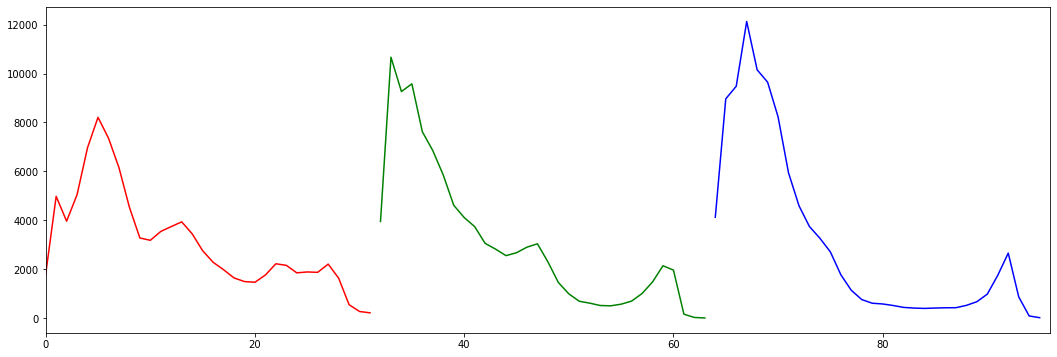

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(18, 6))

# plt.plot(list(range(32)), vec[:32], color='red')
# plt.plot(list(range(32, 64)), vec[32:64], color='green')
# plt.plot(list(range(64, 96)), vec[64:96], color='blue')

# plt.xlim(0, 96)

# plt.show()

In [ ]:
# image_vectors = []
# for image in dataset:
#     image_vectors.append(get_vector(image))

In [ ]:
# dist = np.linalg.norm(image_vectors[0] - image_vectors[1])
# dist

34163.56

In [ ]:
# def euclidean(a, b):
#     return np.linalg.norm(a - b)
# def cosine(a, b):
#     return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
# rgb_images = np.array([np.flip(image, 2) for image in dataset])

# k = 10
# knn = NearestNeighbors(n_neighbors=k, metric=metric)
# knn.fit(ls)

# def search(idx, top_k=5):
#     query_vector = image_vectors[idx]
#     distance, neighbors_idx = knn.kneighbors(query_vector)
#     distances = []
#     for _, vector in enumerate(image_vectors):
#         distances.append(cosine(query_vector, vector))
#     # get top k most similar images
#     top_idx = np.argpartition(distances, -top_k)[-top_k:]
#     return top_idx

<ipython-input-31-000d6c18ee5d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgb_images = np.array([np.flip(image, 2) for image in dataset])


In [ ]:
# search(0)

array([12, 87, 85, 43,  0])

In [ ]:
# def visualize(query_i, results_i):
#     query = rgb_images[query_i]
#     span = int(len(image_vectors[0])/3)
#     results = rgb_images[results_i]
#     top_k = len(results)
#     # visualize query image and it's color histogram
#     fig, axs = plt.subplots(1, 2, figsize=(18, 10))
#     axs[0].imshow(query)
#     axs[0].axis('off')
#     axs[1].plot(image_vectors[query_i][:span], 'r', label='red')
#     axs[1].plot(image_vectors[query_i][span:span*2], 'g', label='green')
#     axs[1].plot(image_vectors[query_i][span*2:], 'b', label='blue')
#     plt.show()
#     # visualize top k images and their color histograms
#     fig0, axs0 = plt.subplots(1, top_k, figsize=(top_k*5, 5))
#     fig1, axs1 = plt.subplots(1, top_k, figsize=(top_k*5, 5), sharey=True)
#     for i in range(top_k):
#         axs0[i].imshow(results[i])
#         axs0[i].axis('off')
#         axs1[i].plot(image_vectors[results_i[i]][:span], 'r', label='red')
#         axs1[i].plot(image_vectors[results_i[i]][span:span*2], 'g', label='green')
#         axs1[i].plot(image_vectors[results_i[i]][span*2:], 'b', label='blue')

In [ ]:
# results_i = search(0)

In [ ]:
# results_i

array([12, 87, 85, 43,  0])

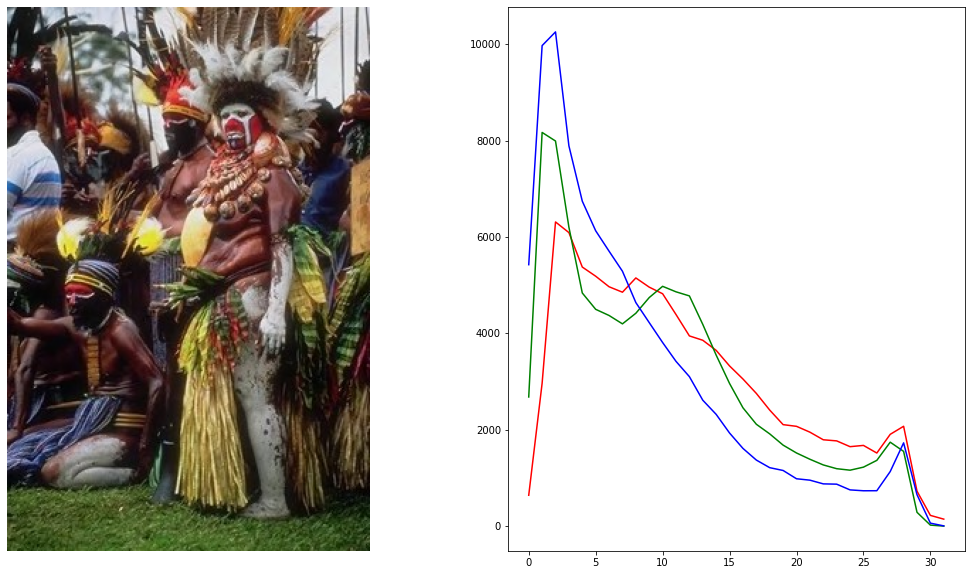

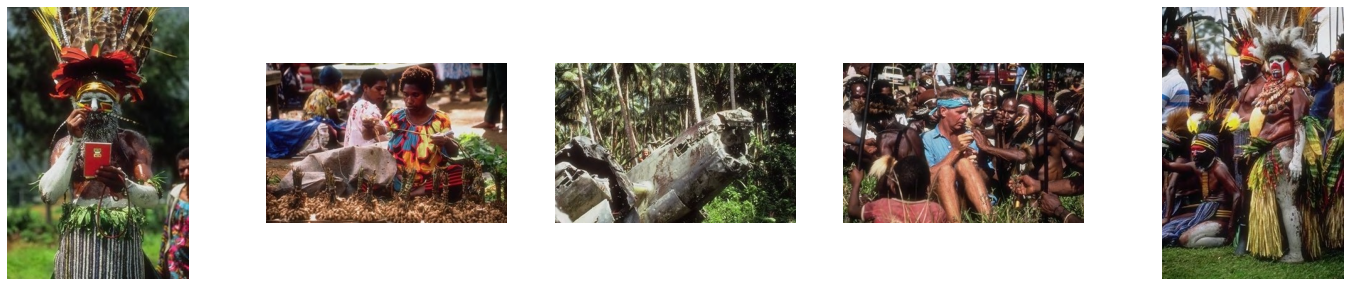

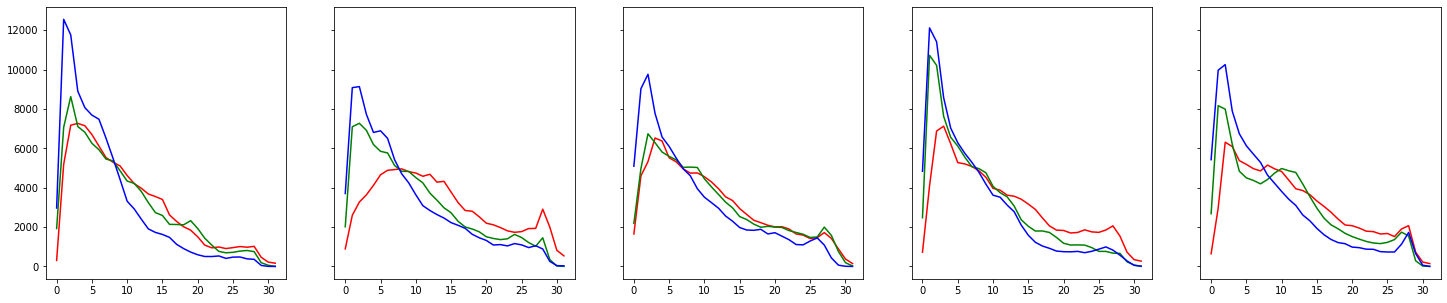

In [ ]:
# img = 6
# visualize(img, search(img))